In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout, concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Bidirectional, LSTM, SimpleRNN, Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from att import Attention

# import tensorflow.keras
from tqdm import tqdm
import time
import pywt, io, PIL, os, scipy, scipy.io.wavfile, librosa, shutil
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from PIL import Image
import numpy as np

from io import BytesIO
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, Normalizer
import threading
import pandas as pd

Using TensorFlow backend.


In [2]:
from sklearn.tree import DecisionTreeClassifier  # 导入DecisionTreeClassifier函数
from sklearn.model_selection import train_test_split
from sklearn import metrics  # 分类结果评价函数
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

### CreateModel

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Public Packages

In [4]:
def plot_signal_decomp(data, w, title, tag):
        """Decompose and plot a signal S.
        S = An + Dn + Dn-1 + ... + D1
        """
        ca = []  # 近似分量
        cd = []  # 细节分量
        w = pywt.Wavelet(w)
        if tag=='vibration':
            a = data
            for i in range(2):
                (a, d) = pywt.dwt(a, w, pywt.Modes.smooth)
                ca.append(a)
                cd.append(d)
        elif tag=='fusion':
            for i in range(9):
                (a, d) = pywt.dwt(data, w, pywt.Modes.smooth)
                ca.append(a)
                cd.append(d)
        rec_a = []
        rec_d = []
        for i, coeff in enumerate(ca):
            coeff_list = [coeff, None] + [None] * i
            rec_a.append(pywt.waverec(coeff_list, w))  # 重构
            
        for i, coeff in enumerate(cd):
            coeff_list = [None, coeff] + [None] * i
            rec_d.append(pywt.waverec(coeff_list, w))
        return rec_a, rec_d

In [5]:
def Cal(data, length):
    data = list(data)
    ind = data.index(max(data))
    if (length/2) <= ind <= (len(data)-(length/2)):
        return np.array(data[int(ind-(length/2)): int(ind+(length/2))])
    elif ind<(length/2):
        return np.array(data[: length])
    elif len(data) - ind<(length/2):
        return np.array(data[-length: ])
    else:
         print('error!!')

In [6]:
def PrePro(x):
    scaler = Normalizer().fit(x)
    testX = scaler.transform(x)
    return [testX]

#### a. 机器学习--语音信号

In [7]:
def AudioMining(path_AM, weight_AM):
    MLresult0=[]
    for audio in os.listdir(path_AM):
        y, sr = librosa.load(os.path.join(path_AM,audio), mono=True)
        
        #均值
        mean_value = y.mean()
        standard_deviation = y.std()
        #均方根
        RMS = np.sqrt(pow(mean_value,2) + pow(standard_deviation,2))
        #峰值
        Peak = max(y)-min(y)
        #偏度
        Skewness =pd.Series(y).skew()
        #峰度
        Kurtosis =pd.Series(y).kurt()
        sum=0
        for i in range(len(y)):
            sum+=np.sqrt(abs(y[i]))
        #波形因子
        Waveform_factor=RMS / (abs(y).mean())
        #峰值因子
        Peak_factor=(max(y)) / RMS
        #脉冲因子
        Pulse_factor=(max(y)) / (abs(y).mean())
        #裕度因子
        Margin_factor=max(y)/ pow(sum/(len(y)),2)
        #峭度
        Steepness  =(np.sum([x**4 for x in y])/len(y)) / pow(RMS,4)
        #   Spectral_flux = SF(y=y, sr=sr)
        
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        # to_append.
        Features = f'{standard_deviation} {Peak} {Skewness} {Kurtosis} {Waveform_factor} {Peak_factor} {Pulse_factor} {Margin_factor} {Steepness} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            Features += f' {np.mean(e)}'
        
        with open(weight_AM , "rb") as f:
            model = pickle.load(f)
        result = model.predict([np.array(Features.split(), dtype=object)])
        MLresult0.append(int(result)+1)
        
    return MLresult0

#### 数据挖掘--一维振动信号

In [8]:
# 模型结构：双向GRU + Attention + FC
def ASRNN():
    inputs = Input(shape=(1, 3600, ), name="input")
    lstm = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True), name="bi-lstm")(inputs)
    gru = Bidirectional(GRU(128, dropout=0.2, return_sequences=True), name="bi-gru")(inputs)
    
    attention1 = Attention(32, name="attention1")(lstm)
    attention2 = Attention(32, name="attention2")(gru)
#     output = GlobalAveragePooling2D()(x)

    output = concatenate([attention1, attention2], axis=-1)
    output = Dense(7, activation='softmax', name="dense")(output)
    model = Model(inputs, output)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    model.build((1, 3600, )) 
    return model

In [9]:
def VibrationMining(path_VM, weight_VM):
    Materials = os.listdir(path_VM)
    DMresult1 = []
    Feature = np.empty(shape=(1, 1, 3600))
    model = ASRNN()
    model.load_weights(weight_VM)
    for name_wave in tqdm(Materials):
        signal=[]
        wave_path_sigle = os.path.join(path_VM, name_wave)
        Wavelet = 'coif8'
        data = np.loadtxt(wave_path_sigle, dtype=object)
        
        An, D = plot_signal_decomp(data, Wavelet, "DWT: Signal irregularity", 'fusion') 
        Data = np.concatenate((An, D))
        length = 200
        for sig in Data:
            signal.extend(Cal(sig, length))
        y = PrePro(np.array(signal).reshape(1,-1))
        Feature = np.vstack((Feature[1:], y))
        
        x_test = Feature
        y_probs = model.predict(x_test)
        y_pred= np.argmax(y_probs,axis=1)
        DMresult1.append(int(y_pred)+1)
    return DMresult1

#### b. 融合图像识别

In [10]:
def ConvPool(x, i):
    x = Conv2D(64, (3, 3), name = "conv1_"+str(i))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.01)(x)
    x = Conv2D(64, (3, 3), name = "conv2_"+str(i))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), name = "mp_"+str(i))(x)
    return x


def SCNN():
    inputs = Input(shape=(width, height, 3))
    x = Conv2D(32, kernel_size=(3, 3), name = "conv1", padding='same')(inputs)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    for i in range(3):
        x = ConvPool(x, i)
        
    output = GlobalAveragePooling2D()(x)
    output = Dense(64, name = "Dense1")(output)
    output = Dense(7, name = "Dense2", activation='softmax')(output)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics = ['accuracy'])
    model.build((width, height, 3))
    
    return model

In [11]:
def DrawORG(zeniths, azimuths, values):
    r, theta = np.meshgrid(zeniths, azimuths)
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    
    ax.contourf(theta, r, values)
    plt.axis('off')
    
    buffer = io.BytesIO()
    plt.savefig(buffer, bbox_inches = 'tight')
    plt.close()
    images = Image.open(buffer).convert('RGB')
    buffer.close()
    return images

In [12]:
def FusionImageRecognition(path_FIR, saved_weight):
    list_txt = os.listdir(path_FIR)
    FIRresult2 = []
    model = SCNN()
    model.load_weights(saved_weight)
    Wavelet = 'coif8'

    for single_txt in tqdm(list_txt):
        txt = np.loadtxt(os.path.join(path_FIR, single_txt), dtype=object)
        An, D = plot_signal_decomp(list(txt), Wavelet, "DWT: Signal irregularity", 'fusion')
        data_An_Dn = np.concatenate((An, D))
        
        length = 300
        values = []
        for data_f in data_An_Dn:
            DataFeatures = Cal(data_f, length)
    
            scaler = preprocessing.MinMaxScaler()
            DataFeatures =  scaler.fit_transform(DataFeatures.reshape(-1,1))
            values.append(DataFeatures.flatten())
            
        azimuths = np.radians(np.linspace(0, 360, 18))
        zeniths = np.arange(0, length, 1)
        
        pic = DrawORG(zeniths, azimuths, values)
        
        tf.get_logger().setLevel('ERROR')
        x_test = pic.resize((width, height),Image.ANTIALIAS)
        test_images =  np.array(x_test)/ 255.0
        
        images = np.array([test_images])
        y_probs = model.predict(images)
        y_pred= np.argmax(y_probs,axis=1)
#         buffer.close()
        FIRresult2.append(int(y_pred)+1)
    return FIRresult2

In [13]:
# saved_weight=r'D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weights\SCNN-val_acc0.8262-183.hdf5'
# path_FIR = r'D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\data\Vibration'

In [14]:
# width = height = 100
# start = time.perf_counter()
# result = FusionImageRecognition(path_FIR, saved_weight)
# end = time.perf_counter()

# timecost = end - start

#### c. 视觉图像识别

In [15]:
def VisalImageRecognition(path_VisalImage, weight):
    VIRresult3 = []
    imagename = os.listdir(path_VisalImage)
    unet2.model_path = weight
    for img in tqdm(imagename):
        image = Image.open(path_VisalImage + '/' + img)
        VIRresult3.append(unet2.detect_image(image))
    return VIRresult3  

In [16]:
# '''视觉图像'''
# path_images = r'../data/image'
# weight_images = r'./weights/VIR.pth'

In [17]:
# from unet2 import Unet2    
# unet2 = Unet2() 
# VisalImageRecognition(path_images, weight_images)

#### d. 集成学习模块

In [18]:
def LabelMk():
    label = []
    for i in range(7):
        if i == 0:
            label.extend([i+1]*157)
        if i == 1:
            label.extend([i+1]*176)
        if i == 2:
            label.extend([i+1]*149)
        if i == 3:
            label.extend([i+1]*176)            
        if i == 4:
            label.extend([i+1]*169) 
        if i == 5:
            label.extend([i+1]*154)
        if i == 6:
            label.extend([i+1]*135)
            
    Label = np.array(label).flatten()
    return Label

In [24]:
def EnsemblePart(AMresult0, VMresult1, FIRresult2):
    '''SVM, Mode, and BayesianNetwork'''
    df = pd.DataFrame(columns=['AM', 'VM','FIR','Label'])
    df['AM'] = AMresult0
    df['VM'] = VMresult1
    df['FIR'] = FIRresult2
    df['Label'] = LabelMk()
    return df

In [20]:
class AM(threading.Thread):
    def __init__(self, path, weight):
        super(AM, self).__init__()
        self.path = path
        self.weight = weight
    def run(self):
        print('开始Audio识别！')
        self.result = AudioMining(self.path, self.weight)
        print('语音识别运行结束！')
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None

class FIR(threading.Thread):
    def __init__(self, path, weight):
        super(FIR, self).__init__()
        self.path = path
        self.weight = weight
    def run(self):
        print('开始FIR识别！')
        self.result = FusionImageRecognition(self.path, self.weight)
        print('融合图像识别运行结束！')
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None
    
class VIR(threading.Thread):   
    def __init__(self, path, weight):
        super(VIR, self).__init__()
        
        self.path = path
        self.weight = weight
    def run(self):
        print('开始VIR识别！')
        self.result = VisalImageRecognition(self.path, self.weight)
        print('视觉图像识别运行结束！')
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None

class VM(threading.Thread):
    def __init__(self, path, weight):
        super(VM, self).__init__()
        
        self.path = path
        self.weight = weight    
    def run(self):
        print('开始VM识别！')
        self.result = VibrationMining(self.path, self.weight)
        print('振动信号识别运行结束！')
        
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None


In [22]:
# if __name__ == '__main__':
print('---开始---:%s'%time.ctime())

import warnings
warnings.filterwarnings("ignore")

'''音频数据挖掘'''
path_AM = r'../data/Audio'#音频地址
weight_AM = r'./weights/Random Forest.pkl'
'''振动数据挖掘'''
path_VM = r'../data/Vibration'#振动信号
weight_VM = r'./weights/AB-RNN-val_acc0.8808-673.hdf5'

'''融合图像'''
save_path=r'D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weights\SCNN-val_acc0.8262-183.hdf5'
path_FIR = r'D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\data\Vibration'
# path_FIR = path_VM
# save_path=r'./weights/SCNN-val_acc0.8262-183.hdf5'

# '''视觉图像'''
# path_images = r'../data/image'
# weight_images = r'./weights/VIR.pth'

width = height = 100

start = time.perf_counter()
thread1 = AM(path_AM, weight_AM)
thread2 = VM(path_VM, weight_VM)
thread3 = FIR(path_FIR, save_path)

thread_lists = [thread1, thread2, thread3]
# thread_lists = [thread1, thread3, thread4]
for thread in thread_lists:
    thread.start()

thread.join()
end = time.perf_counter()

---开始---:Mon Jan  9 23:30:09 2023
开始Audio识别！开始VM识别！
开始FIR识别！

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


  5%|███▋                                                                            | 52/1116 [01:00<19:50,  1.12s/it]


  9%|███████▎                                                                       | 104/1116 [01:59<18:26,  1.09s/it]


 14%|███████████▏                                                                   | 158/1116 [03:00<16:54,  1.06s/it]


 19%|██████████████▉                                                                | 211/1116 [03:58<15:19,  1.02s/it]


 24%|██████████████████▊                                                            | 265/1116 [04:58<15:48,  1.11s/it]


 29%|██████████████████████▌                                                        | 319/1116 [05:58<14:27,  1.09s/it]


 33%|██████████████████████████▍                                                    | 373/1116 [06:56<12:30,  1.01s/it]


 38%|██████████████████████████████▏                                                | 426/1116 [07:53<12:02,  1.05s/it]


 39%|██████████████████████████████▌                                                | 432/1116 [08:00<12:53,  1.13s/it]

语音识别运行结束！



 44%|██████████████████████████████████▋                                            | 490/1116 [08:42<07:23,  1.41it/s]


 61%|████████████████████████████████████████████████▌                              | 686/1116 [09:20<04:13,  1.70it/s]


 54%|██████████████████████████████████████████▍                                    | 599/1116 [10:02<06:26,  1.34it/s]


 59%|██████████████████████████████████████████████▎                                | 655/1116 [10:44<05:24,  1.42it/s]


 64%|██████████████████████████████████████████████████▍                            | 712/1116 [11:26<04:44,  1.42it/s]


 69%|██████████████████████████████████████████████████████▎                        | 768/1116 [12:08<04:38,  1.25it/s]


 74%|██████████████████████████████████████████████████████████▍                    | 825/1116 [12:50<03:44,  1.30it/s]


 79%|██████████████████████████████████████████████████████████████▋                | 885/1116 [13:33<02:37,  1.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1116/1116 [13:45<00:00,  1.57it/s]

振动信号识别运行结束！


100%|██████████████████████████████████████████████████████████████████████████████| 1116/1116 [15:20<00:00,  2.29it/s]


融合图像识别运行结束！


In [25]:
AMresult1 =  thread1.get_result()
VMresult2 =  thread2.get_result()
FIRresult3 = thread3.get_result()

print("每条耗时: %.4f s" % ((end - start)/len(AMresult1)))   
print("总耗时为: %.4f min" % ((end - start)/60)) 

EnsemblePart(AMresult1, VMresult2, FIRresult3)

每条耗时: 0.8265 s
总耗时为: 15.3720 min


,AM,VM,FIR,Label
0,1,1,4,1
1,1,1,7,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
1111,7,7,7,7
1112,7,7,7,7
1113,7,7,7,7
1114,7,7,7,7


In [26]:
df = EnsemblePart(AMresult1, VMresult2, FIRresult3)

### 2.1 众数

如果没有众数，那么结果按照精度高的而定

In [27]:
am_= vm_= fir_= vir_= 0
sum_mode = []
mode_1=[]
mode_2=[]
for i in range(len(df)):
    result = [df['AM'][i], df['VM'][i], df['FIR'][i]] 
    label = df['Label'][i]
    mode_value = np.unique(result)
    print(result)
    if result[0] == label:
        am_ += 1
    if result[1] == label:
        vm_ += 1
    if int(result[2]) == label:
        fir_ += 1
        
    if len(mode_value)==1 and int(mode_value) == label:
        sum_mode.append(int(mode_value))
        mode_1.append(int(mode_value))
    elif len(mode_value)!=1 and int(result[0]) == label:
        mode_2.append(mode_value)

        sum_mode.append(result[0])
        

# print('AM的精度为：%f'%(am_/ len(df)))
# print('VM的精度为：%f'%(vm_/ len(df)))
# print('FIR的精度为：%f'%(fir_/ len(df)))
# print('VIR的精度为：%f'%(vir_/ len(df)))
# print('集成学习的精度为：%f'%(len(sum_mode)/ len(df)))

print('语音：%f'%(am_/ len(df)))
print('振动信号：%f'%(vm_/ len(df)))
print('融合图像：%f'%(fir_/ len(df)))
print('集成学习：%f'%(len(sum_mode)/ len(df)))
    

[1, 1, 4]
[1, 1, 7]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 3, 1]
[1, 1, 1]
[1, 1, 1]
[1, 4, 5]
[1, 1, 1]
[1, 1, 1]
[1, 4, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 4, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 4, 7]
[1, 1, 1]
[1, 4, 3]
[1, 1, 1]
[1, 1, 1]
[1, 3, 3]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 4]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]


[6, 5, 5]
[6, 5, 5]
[6, 5, 5]
[6, 3, 5]
[6, 5, 5]
[6, 5, 5]
[6, 5, 2]
[6, 5, 5]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[1, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[4, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 2]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 7]
[6, 5, 5]
[6, 6, 6]
[6, 6, 3]
[6, 6, 3]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[5, 6, 6]
[6, 6, 6]
[5, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]
[6, 6, 6]


# 集成学习

### 数据准备

In [28]:
import numpy as np
import pandas as pd
import joblib
from sklearn import svm
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [29]:
data  = np.array(df.iloc[:,:3])
labels = np.array(df.iloc[:,3])

num_example=data.shape[0]
arr=np.arange(num_example)
np.random.shuffle(arr)
data=data[arr]
labels=labels[arr]

In [30]:
data, labels

(array([[5, 5, 5],
        [7, 7, 7],
        [2, 2, 2],
        ...,
        [6, 6, 6],
        [3, 7, 7],
        [2, 2, 2]], dtype=int64),
 array([5, 7, 2, ..., 6, 3, 2]))

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=0, train_size=0.7)

## SVM

In [32]:
# for ker in ['rbf', 'linear', 'poly', 'rbf', 'sigmoid']:
clf = svm.SVC(C=1, kernel= 'rbf', decision_function_shape='ovr')
clf.fit(x_train, y_train, sample_weight=None)
NAME = 'SVM_3'
path_weight = r'../weight'+'/'+NAME+'.m'
# os.remove(path_weight)
joblib.dump(clf, path_weight)
print("训练完毕，权重已保存至",os.path.join(os.path.abspath(os.curdir),path_weight[3:]))

训练完毕，权重已保存至 D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weight/SVM_3.m


### test of SVM

##### 2.2.1批量数据测试

In [33]:
clf_test = joblib.load(path_weight)
acc = clf_test.predict(x_test) == np.array(y_test).flat
print('预测:\n',clf_test.predict(x_test))
# print('gt:\n',x_test)
print('真值:\n',y_test)
print('预测精度为：', clf_test.score(x_test,np.array(y_test)))

预测:
 [2 7 2 5 1 2 2 4 4 5 6 5 2 4 5 2 3 4 3 2 6 3 1 3 5 1 7 1 3 6 7 2 1 6 4 4 1
 7 2 5 4 1 2 7 2 4 2 2 5 1 4 1 5 6 1 7 1 4 7 4 6 5 1 2 3 1 1 4 2 7 2 5 7 1
 5 2 4 5 7 6 2 6 7 7 6 6 5 5 2 1 7 6 2 7 2 6 7 6 1 5 7 3 5 7 5 7 2 6 5 2 1
 4 2 6 1 7 7 7 1 3 6 5 5 3 4 7 3 4 2 6 6 7 1 5 6 5 6 2 4 2 1 2 3 7 5 5 4 1
 6 5 4 6 5 4 7 2 4 5 7 7 1 2 5 5 2 1 1 4 6 2 6 7 6 6 3 4 6 7 5 4 7 1 3 5 4
 3 7 6 4 2 2 4 1 2 5 5 1 2 2 1 2 6 2 6 6 4 6 4 7 3 6 6 3 7 3 3 6 6 2 3 1 2
 5 6 6 6 6 2 5 3 6 2 4 2 1 3 5 1 6 6 1 4 4 6 2 6 3 2 7 6 6 4 2 7 4 3 3 2 6
 5 1 7 3 1 2 5 7 5 4 1 6 4 4 5 7 6 7 7 5 4 4 2 1 4 2 2 6 3 5 2 3 7 6 6 4 2
 4 6 3 1 3 7 2 4 4 3 2 3 1 2 4 4 3 6 1 5 6 1 5 5 1 5 4 6 4 2 4 4 7 2 2 3 1
 3 5]
真值:
 [2 7 2 5 1 2 2 4 4 5 7 5 2 4 5 2 3 4 7 2 6 3 1 7 5 1 7 1 3 6 7 2 1 6 4 4 1
 7 2 5 2 1 2 4 2 4 2 2 7 1 4 1 5 6 1 3 1 4 7 4 6 5 1 2 3 1 1 4 2 7 2 5 7 1
 5 2 4 5 7 6 2 6 3 7 6 6 5 5 2 1 7 6 2 4 2 6 7 6 1 5 7 3 5 7 5 7 2 6 5 1 1
 4 2 6 1 7 7 7 1 3 6 5 5 3 4 7 3 4 2 4 6 7 1 5 6 5 6 2 4 2 1 1 3 7 5 5 4 1
 6 5 4 6 

！！！！！SVM结果可视化

In [34]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [35]:
X_train, X_test, Y_train, Y_test = x_train, x_test, y_train, y_test

In [36]:
classifier = joblib.load(path_weight)
Y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

In [37]:
train_y_pred = classifier.predict(X_train)
test_y_pred = classifier.predict(X_test)

print("训练集：", accuracy_score(train_y_pred, Y_train))
print("测试集：", accuracy_score(test_y_pred, Y_test))


训练集： 0.941101152368758
测试集： 0.9432835820895522


In [38]:
start = time.perf_counter()
classifier.predict(X_test)
end = time.perf_counter()
# print('每条耗时%.6f ms'% (end-start)*1000/len(X_test))
print("每条耗时: %.4f us" % ((end - start)*(10**6)/len(X_test)))   


每条耗时: 3.9343 us


In [40]:
from sklearn import metrics
NAME = 'SVM_3'
y_predict = test_y_pred
 
a= metrics.accuracy_score(Y_test, y_predict) #预测准确率输出

b = metrics.precision_score(Y_test,y_predict,average='macro') #预测宏平均精确率输出
c = metrics.precision_score(Y_test, y_predict, average='micro') #预测微平均精确率输出
d = metrics.precision_score(Y_test, y_predict, average='weighted') #预测加权平均精确率输出
  
e = metrics.recall_score(Y_test,y_predict,average='macro')#预测宏平均召回率输出
f = metrics.recall_score(Y_test,y_predict,average='micro')#预测微平均召回率输出
g = metrics.recall_score(Y_test,y_predict,average='micro')#预测加权平均召回率输出
h = metrics.f1_score(Y_test,y_predict,labels=[0, 1,2,3,4,5,6],average='weighted')#预测加权平均f1-score输出
 
i = metrics.confusion_matrix(Y_test,y_predict)#混淆矩阵输出
j = metrics.classification_report(Y_test, y_predict,digits=4)#分类报告输出

record_ = [a, i, j]
for i_ in record_:
    with open('../ImageRecord/metrics'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

In [41]:
Y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = Y_test.shape[1]

In [42]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


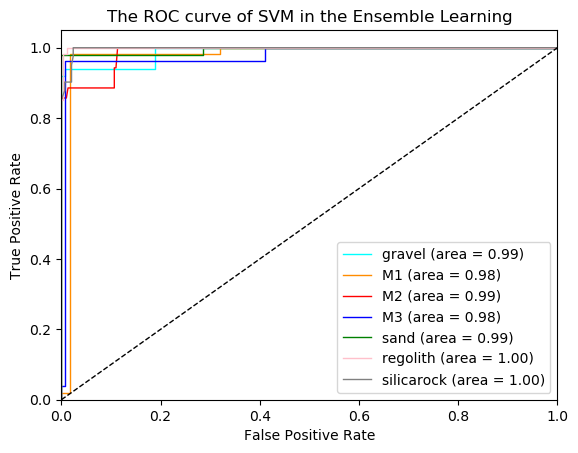

In [43]:

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=1
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'r', 'b', 'g', 'pink', 'gray'])
material = ['gravel', 'M1', 'M2', 'M3', 'sand', 'regolith', 'silicarock']
Score_ = []
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(material[i], roc_auc[i]))
    Score_.append(roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC curve of SVM in the Ensemble Learning')
plt.legend(loc="lower right")
plt.savefig(r'../ImageRecord/ROC_SVM.svg', bbox_inches='tight', transparent=True, dpi=200)
plt.show()


##### 2.2.2单条数据测试

In [46]:
data_t=[[2,2,1]]
result_pred = clf_test.predict(data_t)
print(result_pred)

[2]


## XGBClassifier

In [144]:
# ==============基于Scikit-learn接口的分类================
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [97]:
# 训练模型
y_train_ = y_train-1
y_test_ = y_test-1
XGB = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
xgb_test = XGB.fit(x_train, y_train_)

NAME = 'XGBClassifier'
path_weight = r'../weight'+'/'+NAME+ '.m'
# os.remove(path_weight)
joblib.dump(xgb_test, path_weight)
print("训练完毕，权重已保存至",os.path.join(os.path.abspath(os.curdir),path_weight[3:]))

[00:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


训练完毕，权重已保存至 D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weight/XGBClassifier.m


In [98]:
xgb_test = joblib.load(path_weight)
acc = xgb_test.predict(X_test) == np.array(y_test_).flat
# print('预测:\n',clf_test.predict(X_test))
# print('gt:\n',x_test)
# print('真值:\n',y_test)
print('预测精度为：', xgb_test.score(x_test,y_test_))

预测精度为： 0.9731343283582089


In [99]:
start = time.perf_counter()
xgb_test.predict(X_test)
end = time.perf_counter()
# print('每条耗时%.6f ms'% (end-start)*1000/len(X_test))
print("每条耗时: %.4f us" % ((end - start)*(10**6)/len(X_test)))   


每条耗时: 4.7009 us


In [100]:
from sklearn import metrics
y_predict = xgb_test.predict(X_test)


a= metrics.accuracy_score(y_test_, y_predict) #预测准确率输出
b = metrics.precision_score(y_test_,y_predict,average='macro') #预测宏平均精确率输出
c = metrics.precision_score(y_test_, y_predict, average='micro') #预测微平均精确率输出
d = metrics.precision_score(y_test_, y_predict, average='weighted') #预测加权平均精确率输出
  
e = metrics.recall_score(y_test_,y_predict,average='macro')#预测宏平均召回率输出
f = metrics.recall_score(y_test_,y_predict,average='micro')#预测微平均召回率输出
g = metrics.recall_score(y_test_,y_predict,average='micro')#预测加权平均召回率输出
h = metrics.f1_score(y_test_,y_predict,labels=[0, 1,2,3,4,5,6],average='weighted')#预测加权平均f1-score输出
 
i = metrics.confusion_matrix(y_test_,y_predict)#混淆矩阵输出
j = metrics.classification_report(y_test_, y_predict,digits=4)#分类报告输出

record_ = [a, i, j]
for i_ in record_:
    with open('../ImageRecord/metrics'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

## KNeighborsClassifier

In [139]:
from sklearn import neighbors

In [140]:
knn = neighbors.KNeighborsClassifier(1, weights="uniform")  #修改第一个参数的值可以变为KNN_N近邻
Knn=knn.fit(X_train, Y_train)

NAME = 'KNeighborsClassifier'
path_weight = r'../weight'+'/'+NAME+ '.m'
# os.remove(path_weight)
joblib.dump(Knn, path_weight)
print("训练完毕，权重已保存至",os.path.join(os.path.abspath(os.curdir),path_weight[3:]))

训练完毕，权重已保存至 D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weight/KNeighborsClassifier.m


In [141]:
knn_test = joblib.load(path_weight)
acc = knn_test.predict(X_test) == np.array(y_test).flat
# print('预测:\n',knn_test.predict(X_test))
# # print('gt:\n',x_test)
# print('真值:\n',y_test)
print('预测精度为：', knn_test.score(X_test,np.array(y_test)))

预测精度为： 0.9552238805970149


In [142]:
from sklearn import metrics
y_predict = knn_test.predict(X_test)


a= metrics.accuracy_score(y_test, y_predict) #预测准确率输出
b = metrics.precision_score(y_test,y_predict,average='macro') #预测宏平均精确率输出
c = metrics.precision_score(y_test, y_predict, average='micro') #预测微平均精确率输出
d = metrics.precision_score(y_test, y_predict, average='weighted') #预测加权平均精确率输出
  
e = metrics.recall_score(y_test,y_predict,average='macro')#预测宏平均召回率输出
f = metrics.recall_score(y_test,y_predict,average='micro')#预测微平均召回率输出
g = metrics.recall_score(y_test,y_predict,average='micro')#预测加权平均召回率输出
h = metrics.f1_score(y_test,y_predict,labels=[0, 1,2,3,4,5,6],average='weighted')#预测加权平均f1-score输出
 
i = metrics.confusion_matrix(y_test,y_predict)#混淆矩阵输出
j = metrics.classification_report(y_test, y_predict,digits=4)#分类报告输出

record_ = [a, i, j]
for i_ in record_:
    with open('../ImageRecord/metrics'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

In [143]:
start = time.perf_counter()
knn_test.predict(X_test)
end = time.perf_counter()
# print('每条耗时%.6f ms'% (end-start)*1000/len(X_test))
print("每条耗时: %.4f us" % ((end - start)*(10**6)/len(X_test)))   


每条耗时: 17.4307 us


## 贝叶斯网络

In [145]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [146]:
BN = GaussianNB()
BN.fit(X_train,Y_train)

NAME = 'GaussianNB'
path_weight = r'../weight'+'/'+NAME+ '.m'
# os.remove(path_weight)
joblib.dump(BN, path_weight)
print("训练完毕，权重已保存至",os.path.join(os.path.abspath(os.curdir),path_weight[3:]))

训练完毕，权重已保存至 D:\Triage\Bayesian_Network\NetworkM\EnsembleLearning\code\weight/GaussianNB.m


In [147]:
bn_test = joblib.load(path_weight)
# acc = bn_test.predict(X_test) == np.array(y_test).flat
# print('预测:\n',knn_test.predict(X_test))
# # print('gt:\n',x_test)
# print('真值:\n',y_test)
print('预测精度为：', bn_test.score(X_test,np.array(y_test)))

预测精度为： 0.9074626865671642


In [148]:
from sklearn import metrics
y_predict = bn_test.predict(X_test)


a= metrics.accuracy_score(y_test, y_predict) #预测准确率输出
b = metrics.precision_score(y_test,y_predict,average='macro') #预测宏平均精确率输出
c = metrics.precision_score(y_test, y_predict, average='micro') #预测微平均精确率输出
d = metrics.precision_score(y_test, y_predict, average='weighted') #预测加权平均精确率输出
  
e = metrics.recall_score(y_test,y_predict,average='macro')#预测宏平均召回率输出
f = metrics.recall_score(y_test,y_predict,average='micro')#预测微平均召回率输出
g = metrics.recall_score(y_test,y_predict,average='micro')#预测加权平均召回率输出
h = metrics.f1_score(y_test,y_predict,labels=[0, 1,2,3,4,5,6],average='weighted')#预测加权平均f1-score输出
 
i = metrics.confusion_matrix(y_test,y_predict)#混淆矩阵输出
j = metrics.classification_report(y_test, y_predict,digits=4)#分类报告输出

record_ = [a, i, j]
for i_ in record_:
    with open('../ImageRecord/metrics'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

In [149]:
start = time.perf_counter()
bn_test.predict(X_test)
end = time.perf_counter()
# print('每条耗时%.6f ms'% (end-start)*1000/len(X_test))
print("每条耗时: %.4f us" % ((end - start)*(10**6)/len(X_test)))   


每条耗时: 1.8737 us
